# ML Pipeline Preparation


### Import libraries and load data


In [39]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import make_scorer, classification_report, f1_score
from sklearn.multioutput import MultiOutputClassifier
# from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words'])
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(); color='rebeccapurple'
%matplotlib inline  

# display settings
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_columns', None)  

import time
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-dat

In [2]:
# load data from database with `read_sql_table`
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages', engine)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25992 entries, 0 to 25991
Data columns (total 39 columns):
id                        25992 non-null int64
message                   25992 non-null object
original                  10021 non-null object
genre                     25992 non-null object
related                   25992 non-null int64
request                   25992 non-null int64
offer                     25992 non-null int64
aid_related               25992 non-null int64
medical_help              25992 non-null int64
medical_products          25992 non-null int64
search_and_rescue         25992 non-null int64
security                  25992 non-null int64
military                  25992 non-null int64
water                     25992 non-null int64
food                      25992 non-null int64
shelter                   25992 non-null int64
clothing                  25992 non-null int64
money                     25992 non-null int64
missing_people            25992 non-null i

## Split data into training and test sets (with stratified sampling)
Based on the results of the EDA (documented in separate `EDA.ipynb`) stratfied sampling is used for splitting into training and test set. The proportion of the different _numbers of active categories per message_ is to be preserved.

In [4]:
# create new column with total number of active categories per message
df['total'] = df.iloc[:,4:40].sum(axis=1)
# for StratifiedShuffleSlpit to work properly all values > 10 in ['total'] column will be set to 11. (Kind of oultier removal.)
df['total'] = np.where((df['total'] >10), 11, df['total'])

In [5]:
# create testset with stratified sampling according to the category count per message
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 111)
for train_index, test_index in split.split(df, df['total']):
    train = df.loc[train_index]
    test = df.loc[test_index]
    
# safety-check
assert np.abs(len(test) - (len(df) * 0.2)) <= 1, 'split got messed up'
assert (round(df['related'].sum() / len(df),3)) == (round(train['related'].sum() / len(train),3)), 'not properly stratisfied'

In [6]:
# remove 'total' column from train and test sets
for set_ in (train, test):
    set_.drop('total', axis=1, inplace=True)
    
# safety-check
assert len(test.columns) == 39

## Split into features an target variables

In [14]:
X_train = train['message'].values
Y_train = train.iloc[:, 4:39].values

X_test = test['message'].values
Y_test = test.iloc[:, 4:39].values

In [15]:
#check
X_train[:2]

array(['Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'Good evening to all USA soldiers. we still suffer from this great event. We would love to handle your presence of authority. thank you'],
      dtype=object)

In [16]:
#check
Y_train[:2]

array([[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

## Preprocessing

### Define tokenization function

In [17]:
def tokenize_text(message):
    """Tokenization function to process text data. """
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize case and remove punctuation
    message = re.sub(r"[^a-zA-Z0-9]", " ", message.lower())
    # tokenize text
    tokens = word_tokenize(message)
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word.strip()) for word in tokens if word not in stop_words]
    # add part-of-speech tags
    tokens = pos_tag(tokens)
    
    return tokens

In [18]:
# check
for message in X_train[:2]:
    tokens = tokenize_text(message)
    print(message)
    print(tokens, '\n')

Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.
[('2', 'CD'), ('000', 'CD'), ('woman', 'NN'), ('protesting', 'VBG'), ('conduct', 'NN'), ('election', 'NN'), ('teargassed', 'VBD'), ('tried', 'JJ'), ('converge', 'NN'), ('local', 'JJ'), ('electoral', 'JJ'), ('commission', 'NN'), ('office', 'NN'), ('southern', 'JJ'), ('oil', 'NN'), ('city', 'NN'), ('port', 'NN'), ('harcourt', 'NN')] 

Good evening to all USA soldiers. we still suffer from this great event. We would love to handle your presence of authority. thank you
[('good', 'JJ'), ('evening', 'NN'), ('usa', 'NN'), ('soldier', 'NN'), ('still', 'RB'), ('suffer', 'VBZ'), ('great', 'JJ'), ('event', 'NN'), ('would', 'MD'), ('love', 'VB'), ('handle', 'VB'), ('presence', 'NN'), ('authority', 'NN'), ('thank', 'NN')] 



### Build preprocessing pipeline

In [19]:
# define the classifier, wrapped in MultiOutputClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

# build the pipeline
pre_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
              ])

start = time.time()


X_train = pre_pipe.fit_transform(X_train)
# train the pipeline
# X_train = pipe.fit(X_train, Y_train)
# # predict labels on test_set
# Y_pred = model.predict(X_test)

print('Duration: {} seconds'.format(time.time() - start))

Duration: 38.19412016868591 seconds


### Test different baseline models

Evaluation of different possible classifiers, Validation with stratified k-fold CV. Models are:
- LogisticRegression 
- RandomForestClassifier 
- XGBClassifier
- SVC

To handle the multi-labels they are wrapped into scikit-learn's [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) ([example here](https://scikit-learn.org/stable/modules/multiclass.html#multioutput-classification)).


In [43]:
classifiers = {'LogReg' :MultiOutputClassifier(LogisticRegression(solver='liblinear')),
#                'Random Forest' : MultiOutputClassifier(RandomForestClassifier(n_estimators=50)),
#                'Gradient Boosting' : MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50)),
#                'SVC' : MultiOutputClassifier(SVC(gamma='auto'))
                }

scorer = make_scorer(f1_score, average='weighted')

In [102]:
# for each model, fit to train set and validate with stratified 3-fold CV, store results in nested dict

def compare_models(model_dict, X_train, y_train, scorer, cv=StratifiedKFold(3)): # ACHTUNG STRING GEHT WOHL NICHT
    """Fit defined models to the train set and cross validate the results. 
       (This Funcion is built on top of sk-learn's cross_validate function.)
              
       ARGUMENTS:
       model_dict: dict of names (k) and sk-learn model objects (v)
       X_train: training features (df or array)
       y_train: training labels (df or array)
       cv: type of CV, default is StratifiedKFold(3)
       scorer: evaluation metric for validation
       
       RETURNS:
       results: dataframe with metrics.
"""
    # store results of cross_validate in nested dict
    results = {}
    
    for name, model in tqdm(model_dict.items()):
        try:  # standard type for data input is df
            name = name
            scores = cross_validate(
                model, X_train, y_train, cv=cv, error_score='raise', 
                n_jobs=-1, scoring=scorer, return_train_score=False, 
                return_estimator=True
            )
        except:  # exception for classifiers that need data as array
            name = name
            scores = cross_validate(
                model, X_train.toarray(), y_train, cv=cv, 
                error_score='raise', n_jobs=-1,
                scoring=scorer, return_train_score=False, 
                return_estimator=True
            )
        
    results[name] = scores
    
    # create dataframe with extra metrics (95_conf, total_time)
    results = pd.DataFrame(results).T
    results['estimator'] = results['estimator'].apply(lambda x: x[0])
    results['95_conf'] = \
        results['test_score'].apply(lambda x: np.std(x) * 2)
    for col in results.iloc[:,1:]:
        results[col] = results[col].apply(lambda x: np.mean(x))
    results['total_time'] = results['score_time'] + results['fit_time']
    results = results[['estimator', 'test_score', '95_conf', 
                  'total_time', 'fit_time', 'score_time']]
    
    return results

In [107]:
# define a function for plotting the main results of the model comparision
def plot_comparision(results):
    """Plot copmarision of test scores and run times for cross validated
       models.
       
       ARGUMENTS:
       results: dataframe generated with 'compare_models' function.
       """
    data = results.sort_values(by='test_score', ascending=False)
    plt.figure(figsize=(18,6));
    plt.subplot(1,2,1)
    # plot the mean test scores
    sns.barplot(x='test_score', y=data.index, data=data, color="rebeccapurple")
    plt.xlabel(scorer);
    plt.subplot(1,2,2)
    # Plot the mean total time
    sns.set_color_codes("pastel")
    sns.barplot(x="total_time", y=data.index, data=data,
        label="Total", color="rebeccapurple")
    # Plot the mean fit time
    sns.set_color_codes("muted")
    sns.barplot(x='fit_time', y=data.index, data=data,
        label="Fit", color="yellow")
    plt.xlabel("Time for fitting (yellow) and scoring (purple)");

In [108]:
eval_results = evaluate_models(classifiers, X_train, Y_train, scorer, cv=3)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.01s/it]


In [109]:
eval_results

,estimator,test_score,95_conf,total_time,fit_time,score_time
LogReg,"MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='liblinear',\n tol=0.0001, verbose=0, warm_start=False),\n n_jobs=None)",0.533876,0.004504,4.190742,4.057194,0.133548


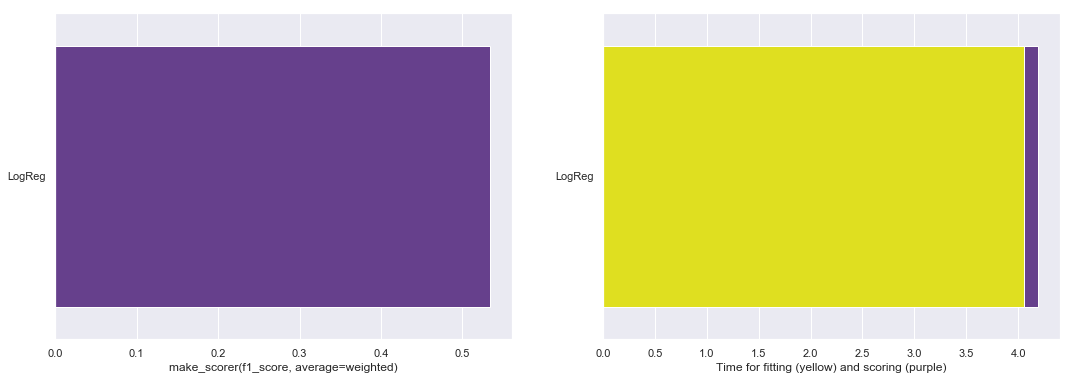

In [110]:
plot_comparision(eval_results)

In [76]:


# specify parameters for grid search
parameters = {
    'clf': [MultiOutputClassifier(LogisticRegression(solver='liblinear')),
            MultiOutputClassifier(RandomForestClassifier(n_estimators=50)),
            MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50)),
            MultiOutputClassifier(SVC(gamma='auto'))
            ]
    }
  
# create grid search object
cv = GridSearchCV(pipe, param_grid=parameters, 
                  scoring=scorer, cv=3, n_jobs=1, 
                  verbose=1)



In [ ]:
start = time.time()
cv.fit(X_train, y_train)
print('Duration: {} seconds'.format(time.time() - start))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', av

In [ ]:
sorted(cv.cv_results_.keys())

In [40]:
evaluate_multilabel(Y_test, Y_pred)

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


,f1-score,precision,recall,support
related,0.889883,0.836766,0.950201,3976.0
request,0.603854,0.816602,0.479049,883.0
offer,0.000000,0.000000,0.000000,32.0
aid_related,0.695568,0.731880,0.662689,2179.0
medical_help,0.099602,0.641026,0.053996,463.0
medical_products,0.112211,0.894737,0.059859,284.0
search_and_rescue,0.119048,0.769231,0.064516,155.0
security,0.023256,1.000000,0.011765,85.0
military,0.139303,0.700000,0.077348,181.0
water,0.429561,0.853211,0.287037,324.0


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [39]:
def evaluate_multilabel(Y_real, Y_pred):
    """Calculate evaluation metrics for ML model
    
    ARGUMENTS:
    Y_real: Array containing actual labels.
    Y_pred: Array containing predicted labels.
       
    RETURNS:
    metrics_df: Dataframe containing the multilabel
    classification report.
    """
    
    # create list of strings with target class names
    target_names = train.iloc[:, (-1 * Y_train.shape[1]):].columns
    
    # Calculate classification report
    metrics = classification_report(
                Y_real, Y_pred,
                target_names=target_names,
                output_dict=True,
                )

    # Create dataframe, tanspose it
    metrics_df = pd.DataFrame(
                    data = metrics, 
                    ).T
      
    return metrics_df

### 6. Improve your model
Use grid search to find better parameters. 

In [17]:
parameters = 

cv = 

SyntaxError: invalid syntax (<ipython-input-17-84949413bfaa>, line 1)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [ ]:
target_names = list(train.iloc[:, (-1 * y_train.shape[1]):].columns)
target_names

- fun evaluate: set columns in col_names to right

- to do: concatenate one hot encoded genre with text
- eventually length and total categories to

In [ ]:
y_train.shape

In [12]:
# define the classifier, wrapped in MultiOutputClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

# build the pipeline
pre_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(clf, n_jobs=-1)),
              ])

start = time.time()

# train the pipeline
model = pipe.fit(X_train, Y_train)
# predict labels on test_set
Y_pred = model.predict(X_test)

print('Duration: {} seconds'.format(time.time() - start))

Duration: 323.91256976127625 seconds
